In [1]:
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
import os
import io
from io import StringIO
from datetime import datetime as dt
import numpy as np

In [2]:
netflix_file = "../ETL_Project/netflix.csv"
#path to csv fileC:
# netflix_file = "../ETL_Project/netflix_titles.csv"

#Read in csv file  
netflix_df = pd.read_csv(netflix_file)

#split rows that have multiple countries in a single row and stack them into the a new df
netflix_df_2 = netflix_df.Country.str.split(',').apply(pd.Series, 1).stack()

#drop the index from intial df and join both dfs
netflix_df_2.index = netflix_df_2.index.droplevel(-1)
netflix_df_2.name = 'Country'
del netflix_df['Country']
netflix_df = netflix_df.join(netflix_df_2)

In [3]:
#removed unnecessary columns
netflix_col=["Title", "Category", "Year", "Country", "Rating", "List"]
netflix_transformed=netflix_df[netflix_col].copy()

#count of values in the columns
netflix_transformed.count()

Title       7658
Category    7658
Year        7647
Country     7182
Rating      7648
List        7658
dtype: int64

In [4]:
#drop rows that do not have a value in 'country' column
netflix_transformed= netflix_transformed.dropna(subset=['Country'])
netflix_transformed.count()

Title       7182
Category    7182
Year        7173
Country     7182
Rating      7176
List        7182
dtype: int64

In [5]:
#drop rows that do not have a value in 'date added' column
netflix_transformed= netflix_transformed.dropna(subset=['Year'])
print(netflix_transformed.count())

#view the df
netflix_transformed

Title       7173
Category    7173
Year        7173
Country     7173
Rating      7167
List        7173
dtype: int64


,Title,Category,Year,Country,Rating,List
0,Norm of the North: King Sized Adventure,Movie,9-Sep-19,United States,TV-PG,"Children & Family Movies, Comedies"
0,Norm of the North: King Sized Adventure,Movie,9-Sep-19,India,TV-PG,"Children & Family Movies, Comedies"
0,Norm of the North: King Sized Adventure,Movie,9-Sep-19,South Korea,TV-PG,"Children & Family Movies, Comedies"
0,Norm of the North: King Sized Adventure,Movie,9-Sep-19,China,TV-PG,"Children & Family Movies, Comedies"
1,Jandino: Whatever it Takes,Movie,9-Sep-16,United Kingdom,TV-MA,Stand-Up Comedy
...,...,...,...,...,...,...
6218,Talking Tom and Friends,TV Show,"April 10, 2019",Thailand,TV-G,"Kids' TV, TV Comedies"
6219,Pokémon the Series,TV Show,"April 1, 2019",Japan,TV-Y7-FV,"Anime Series, Kids' TV"
6220,Justin Time,TV Show,"April 1, 2016",Canada,TV-Y,Kids' TV
6221,Terrace House: Boys & Girls in the City,TV Show,"April 1, 2016",Japan,TV-14,"International TV Shows, Reality TV"


In [6]:
#extract rows that have "United States" in the 'country' column
netflix_transformed_US = netflix_transformed.loc[(netflix_transformed["Country"]=="United States")]
netflix_transformed_US.count()

Title       2296
Category    2296
Year        2296
Country     2296
Rating      2293
List        2296
dtype: int64

In [7]:
#extract rows that have "Canada" in the 'country' column
netflix_transformed_CA = netflix_transformed.loc[(netflix_transformed["Country"]== "Canada")]
netflix_transformed_CA.count()

Title       206
Category    206
Year        206
Country     206
Rating      206
List        206
dtype: int64

In [8]:
#######Method 3 #######
#join the United States and Canada dfs
netflix_transformed = netflix_transformed_US.append(netflix_transformed_CA)
print(netflix_transformed)
print(netflix_transformed.count())

                                        Title Category             Year  \
0     Norm of the North: King Sized Adventure    Movie         9-Sep-19   
2                          Transformers Prime  TV Show         8-Sep-18   
3            Transformers: Robots in Disguise  TV Show         8-Sep-18   
4                                #realityhigh    Movie         8-Sep-17   
8                                Fire Chasers  TV Show         8-Sep-17   
...                                       ...      ...              ...   
6188             Roman Empire: Reign of Blood  TV Show    April 5, 2019   
6192                        Kim's Convenience  TV Show    April 3, 2019   
6208                                Lost Girl  TV Show   April 17, 2016   
6209                                Mr. Young  TV Show   April 16, 2019   
6220                              Justin Time  TV Show    April 1, 2016   

            Country    Rating                                List  
0     United States     TV-PG  

In [9]:
# drop duplicated indexes
netflix_transformed.drop_duplicates(keep='first')

#view the df
print(netflix_transformed)

                                        Title Category             Year  \
0     Norm of the North: King Sized Adventure    Movie         9-Sep-19   
2                          Transformers Prime  TV Show         8-Sep-18   
3            Transformers: Robots in Disguise  TV Show         8-Sep-18   
4                                #realityhigh    Movie         8-Sep-17   
8                                Fire Chasers  TV Show         8-Sep-17   
...                                       ...      ...              ...   
6188             Roman Empire: Reign of Blood  TV Show    April 5, 2019   
6192                        Kim's Convenience  TV Show    April 3, 2019   
6208                                Lost Girl  TV Show   April 17, 2016   
6209                                Mr. Young  TV Show   April 16, 2019   
6220                              Justin Time  TV Show    April 1, 2016   

            Country    Rating                                List  
0     United States     TV-PG  

In [10]:
# check for duplicated in Movie titles
netflix_transformed_dups = netflix_transformed.duplicated(subset=['Title'])
netflix_transformed_dups

0       False
2       False
3       False
4       False
8       False
        ...  
6188    False
6192    False
6208    False
6209    False
6220    False
Length: 2502, dtype: bool

In [11]:
#count of duplicates found
netflix_transformed_dups.loc[(netflix_transformed_dups == True)].count()

9

In [12]:
# Drop rows with Duplicate Movie title
cleaned_netflix_transformed = netflix_transformed.drop_duplicates(subset=["Title"], keep='last')
cleaned_netflix_transformed

,Title,Category,Year,Country,Rating,List
0,Norm of the North: King Sized Adventure,Movie,9-Sep-19,United States,TV-PG,"Children & Family Movies, Comedies"
2,Transformers Prime,TV Show,8-Sep-18,United States,TV-Y7-FV,Kids' TV
3,Transformers: Robots in Disguise,TV Show,8-Sep-18,United States,TV-Y7,Kids' TV
4,#realityhigh,Movie,8-Sep-17,United States,TV-14,Comedies
8,Fire Chasers,TV Show,8-Sep-17,United States,TV-MA,"Docuseries, Science & Nature TV"
...,...,...,...,...,...,...
6188,Roman Empire: Reign of Blood,TV Show,"April 5, 2019",Canada,TV-MA,Docuseries
6192,Kim's Convenience,TV Show,"April 3, 2019",Canada,TV-14,TV Comedies
6208,Lost Girl,TV Show,"April 17, 2016",Canada,TV-14,"TV Dramas, TV Horror, TV Mysteries"
6209,Mr. Young,TV Show,"April 16, 2019",Canada,TV-G,"Kids' TV, TV Comedies"


In [13]:
sub_file = "../ETL_Project/subscriber.csv"
sub_df = pd.read_csv(sub_file)
sub_df.head()

,Area,Years,Subscribers
0,United States and Canada,Q1 - 2018,60909000
1,"Europe, Middle East and Africa",Q1 - 2018,29339000
2,Latin America,Q1 - 2018,21260000
3,Asia-Pacific,Q1 - 2018,7394000
4,United States and Canada,Q2 - 2018,61870000


In [14]:
# cleaned_netflix_transformed = cleaned_netflix_transformed.rename(columns={"title": "Title","type": "Category",\
#                                                                           "date_added": "Years","country": "Country",\
#                                                                           "rating": "Rating"})

# print(cleaned_netflix_transformed)

In [15]:
# convert the 'Years' column to datetime format
cleaned_netflix_transformed["Year"]=pd.to_datetime(cleaned_netflix_transformed['Year'])

#created a start and end date to grab only the rows between 2018-2020
start_date = '12-31-2017'
end_date = '12-31-2020'

#created a variable to hold the dates
year_filtered_df = (cleaned_netflix_transformed['Year'] > start_date) & (cleaned_netflix_transformed['Year'] <= end_date)

#filtered the rows using the dates variable created
cleaned_netflix_transformed = cleaned_netflix_transformed.loc[year_filtered_df]
cleaned_netflix_transformed

<ipython-input-15-f2e48484f2a0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_netflix_transformed["Year"]=pd.to_datetime(cleaned_netflix_transformed['Year'])


,Title,Category,Year,Country,Rating,List
0,Norm of the North: King Sized Adventure,Movie,2019-09-09,United States,TV-PG,"Children & Family Movies, Comedies"
2,Transformers Prime,TV Show,2018-09-08,United States,TV-Y7-FV,Kids' TV
3,Transformers: Robots in Disguise,TV Show,2018-09-08,United States,TV-Y7,Kids' TV
27,City of Joy,Movie,2018-09-07,United States,TV-MA,Documentaries
31,Sierra Burgess Is A Loser,Movie,2018-09-07,United States,PG-13,"Comedies, Romantic Movies"
...,...,...,...,...,...,...
6145,Workin' Moms,TV Show,2019-08-29,Canada,TV-MA,"International TV Shows, TV Comedies"
6174,Heartland,TV Show,2019-08-01,Canada,TV-PG,TV Dramas
6188,Roman Empire: Reign of Blood,TV Show,2019-04-05,Canada,TV-MA,Docuseries
6192,Kim's Convenience,TV Show,2019-04-03,Canada,TV-14,TV Comedies


In [16]:
cleaned_netflix_transformed["Year"]=pd.to_datetime(cleaned_netflix_transformed['Year'])

#Using Years
cleaned_netflix_transformed["Year"]=cleaned_netflix_transformed["Year"].dt.strftime("%Y")

cleaned_netflix_transformed.head()

<ipython-input-16-3d97548cb402>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_netflix_transformed["Year"]=pd.to_datetime(cleaned_netflix_transformed['Year'])
<ipython-input-16-3d97548cb402>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_netflix_transformed["Year"]=cleaned_netflix_transformed["Year"].dt.strftime("%Y")


,Title,Category,Year,Country,Rating,List
0,Norm of the North: King Sized Adventure,Movie,2019,United States,TV-PG,"Children & Family Movies, Comedies"
2,Transformers Prime,TV Show,2018,United States,TV-Y7-FV,Kids' TV
3,Transformers: Robots in Disguise,TV Show,2018,United States,TV-Y7,Kids' TV
27,City of Joy,Movie,2018,United States,TV-MA,Documentaries
31,Sierra Burgess Is A Loser,Movie,2018,United States,PG-13,"Comedies, Romantic Movies"


In [17]:
cleaned_netflix_transformed=cleaned_netflix_transformed.drop(columns=['Title'])
cleaned_netflix_transformed

,Category,Year,Country,Rating,List
0,Movie,2019,United States,TV-PG,"Children & Family Movies, Comedies"
2,TV Show,2018,United States,TV-Y7-FV,Kids' TV
3,TV Show,2018,United States,TV-Y7,Kids' TV
27,Movie,2018,United States,TV-MA,Documentaries
31,Movie,2018,United States,PG-13,"Comedies, Romantic Movies"
...,...,...,...,...,...
6145,TV Show,2019,Canada,TV-MA,"International TV Shows, TV Comedies"
6174,TV Show,2019,Canada,TV-PG,TV Dramas
6188,TV Show,2019,Canada,TV-MA,Docuseries
6192,TV Show,2019,Canada,TV-14,TV Comedies


In [18]:
#filtered dataframe from specific columns
sub_col=["Area","Years","Subscribers"]
sub_transformed= sub_df[sub_col].copy()
year_sub=sub_transformed["Years"].str.split(" - ").str[1]
sub_transformed["Years"]=sub_transformed["Years"].str.split(" - ").str[1]

In [19]:
print(sub_transformed)
sub_transformed.info()

                               Area Years  Subscribers
0          United States and Canada  2018     60909000
1   Europe,  Middle East and Africa  2018     29339000
2                     Latin America  2018     21260000
3                      Asia-Pacific  2018      7394000
4          United States and Canada  2018     61870000
5   Europe,  Middle East and Africa  2018     31317000
6                     Latin America  2018     22795000
7                      Asia-Pacific  2018      8372000
8          United States and Canada  2018     63010000
9   Europe,  Middle East and Africa  2018     33836000
10                    Latin America  2018     24115000
11                     Asia-Pacific  2018      9461000
12         United States and Canada  2018     64757000
13  Europe,  Middle East and Africa  2018     37818000
14                    Latin America  2018     26077000
15                     Asia-Pacific  2018     10607000
16         United States and Canada  2019     66633000
17  Europe

In [20]:
#filtering using just United States and Canada
cleaned_sub_transformed=sub_transformed.loc[(sub_transformed["Area"]=="United States and Canada")]

print(cleaned_sub_transformed)
cleaned_sub_transformed.info()

                        Area Years  Subscribers
0   United States and Canada  2018     60909000
4   United States and Canada  2018     61870000
8   United States and Canada  2018     63010000
12  United States and Canada  2018     64757000
16  United States and Canada  2019     66633000
20  United States and Canada  2019     66501000
24  United States and Canada  2019     67114000
28  United States and Canada  2019     67662000
32  United States and Canada  2020     69969000
36  United States and Canada  2020     72904000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 36
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Area         10 non-null     object
 1   Years        10 non-null     object
 2   Subscribers  10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 320.0+ bytes


In [22]:
#database connection
connection_string ="postgres:*****@localhost:5432/Netflix"
engine = create_engine(f'postgresql://{connection_string}')

In [23]:
engine.table_names()

['netflix', 'subscribers']

In [24]:
### Load DataFrames into database
cleaned_netflix_transformed.to_sql(name='netflix', con=engine, if_exists='replace', index=True)
cleaned_sub_transformed.to_sql(name='subscribers', con=engine, if_exists='replace', index=True)

In [33]:
# Set index
cleaned_sub_transformed.set_index("id", inplace=True)
# Set index
cleaned_netflix_transformed.set_index("id", inplace=True)

KeyError: "None of ['id'] are in the columns"

In [25]:
#Query confirmed through SQL database for neflix 
pd.read_sql_query('select * from netflix', con=engine).head()

,index,Category,Year,Country,Rating,List
0,0,Movie,2019,United States,TV-PG,"Children & Family Movies, Comedies"
1,2,TV Show,2018,United States,TV-Y7-FV,Kids' TV
2,3,TV Show,2018,United States,TV-Y7,Kids' TV
3,27,Movie,2018,United States,TV-MA,Documentaries
4,31,Movie,2018,United States,PG-13,"Comedies, Romantic Movies"


In [26]:
#Query confirmed through SQL database for Netflix subscribers

pd.read_sql_query('select * from subscribers', con=engine).head()

,index,Area,Years,Subscribers
0,0,United States and Canada,2018,60909000
1,4,United States and Canada,2018,61870000
2,8,United States and Canada,2018,63010000
3,12,United States and Canada,2018,64757000
4,16,United States and Canada,2019,66633000


In [27]:
#The numbers of subscribers 
num_sub =sub_transformed.groupby("Years")
num_sub

In [28]:
max_sub = num_sub["Subscribers"].max()
max_sub

Years
2018    64757000
2019    67662000
2020    72904000
Name: Subscribers, dtype: int64

In [29]:
sub_df= pd.DataFrame({"Subscriber Count": max_sub,})
sub_df.head()

,Subscriber Count
Years,
2018,64757000
2019,67662000
2020,72904000


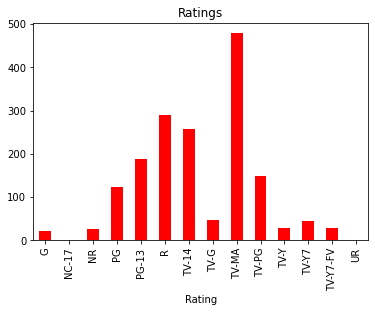

<Figure size 432x288 with 0 Axes>

In [30]:
rating_count = cleaned_netflix_transformed.groupby('Rating')
max_rating_count = pd.DataFrame(rating_count['Rating'].count())
max_rating_count.head()

max_rating_count.plot(kind="bar", figsize=(6,4), color = ["red","blue","green","purple","yellow","orange"], legend=False)
plt.title("Ratings")
plt.show()
plt.tight_layout()

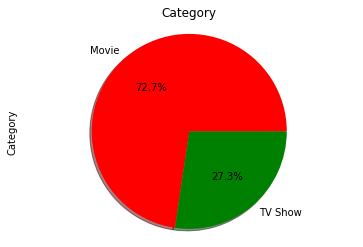

In [31]:
cat_count = cleaned_netflix_transformed.groupby('Category')
max_cat_count = pd.DataFrame(cat_count['Category'].count())
max_cat_count.head()

max_cat_count.plot(kind="pie", y='Category', autopct="%1.1f%%", colors = ["red", "green"], shadow=True, legend=False)
plt.axis("equal")
plt.title("Category")
plt.show()

In [ ]:
# list = cleaned_netflix_transformed[["List"]]
# list_list = list.groupby(["List"])
# list_count_item = list_list["List"].count()
# list_count_names = list_count_item.sort_values(["Count"], ascending=False).head()
# list_count_names

# # list_count_list = list_count_item.sort_values(["List Count"], ascending=False).head()

# # # popular_formatted = popular_formatted.style.format({"Item Price":"${:,.2f}",
# # #                                 "Total Purchase Value":"${:,.2f}"})

# # list_count_list

In [ ]:
# list_count = cleaned_netflix_transformed.groupby('List')
# max_list_count = pd.DataFrame(list_count['List'].count())
# max_list_count.head()

# max_list_count.plot(kind="bar", figsize=(6,4), color = ["black"], legend=False)
# # plt.xlim(-0.75, len(x_axis)-.25)
# plt.ylim(0, max(max_list_count["List"])+10)
# plt.title("List")
# plt.show()
# plt.tight_layout()